# Machine Learning Foundation
## Smoothing

### Introduction
Time series data is data that is measured at equally-spaced intervals, and can be decomposed into trend, seasonality, and residuals. Many time series models require the data to be stationary in order to make forecasts.  In this notebook, we'll build upon these concepts by exploring another important concept called **smoothing**.

# Learning Outcomes
You should walk away from this demonstration with:
1. A practical understanding of smoothing and why it is necessary.
2. Several common smoothing techniques.
3. A basic understanding of how to smooth time series data with Python and generate forecasts.

# Imports

In [1]:
import sys, os
import statsmodels as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
os.chdir('data')
from colorsetup import colors, palette
sns.set_palette(palette)

warnings.filterwarnings('ignore')

### Section 1: Smoothing

In this lesson, we will explore the idea of smoothing a time series. Specifically, we'll discuss what smoothing is and why it is necessary.

As before, we'll generate datasets from scratch to help you grasp the advantages of smoothing. 

### What is Smooothing?
Any data collection process is subject to noise. Oftentimes this noise can obscure useful patterns. Smoothing is a well-known and oft used technique to extract those patterns. 

Smoothing comes in two flavors:
1. Simple 
2. Exponential 

We'll explore these concepts more deeply in a moment. However, before we do, let's kick things off with the stationary data we discussed in the last lesson on stationary time series.

In [3]:
# reproducibility
np.random.seed(42)

# data
time=np.arange(100)
stationary=np.random.normal(loc=0, scale=1.0, size=len(time))

By now you should know that you should always visually inspect your time series with a run-sequence plot. 
> Again, we'll create a *run_sequence_plot* function to make plotting throughout this tutorial less cumbersome.

In [4]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

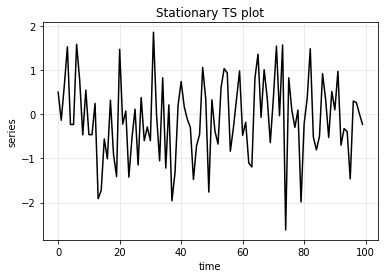

In [6]:
run_sequence_plot(time, stationary, "Stationary TS plot")

### Section 2: Common Smoothing Techniques
This may surprise you but there are many techniques for smoothing data. 

The ones we'll discuss in this tutorial are:
1. Simple Smoothing
2. Moving Average Smoothing
3. Exponential Smoothing

### 1. Simple Smoothing
Simple smoothing is the most obvious place to start. 

Consider the stationary data above. How would you go about extracting information from this series? 

Naturally, your inclination may be to calculate the mean and use that as an estimate to represent the series. 

Let's try that.

In [7]:
# find menad of series
stationary_time_series_mean=np.mean(stationary)

In [9]:
# create array composed of mean value and equal to length of time array
sts_avg = np.full(shape=len(time), fill_value=stationary_time_series_mean, dtype='float')

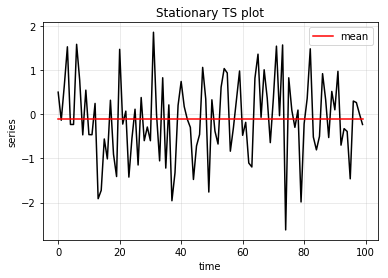

In [11]:
run_sequence_plot(time, stationary, "Stationary TS plot")
plt.plot(time, sts_avg, 'r', label="mean")
plt.legend();

We need a way to measure how far off our estimate is from reality. A common way to do this with continuous data is by calculating Mean Squared Error (MSE). 

The formula for MSE is:  $MSE = \frac{1}{n}\sum_{i=0}^{n} (observed_{i} - estimate_{i})^2$

Let's walk through a quick example to make sure you understand what's happening.

Say we an array of observed values [0, 1, 2, 3] and our estimate is the array [1, 1, 1, 1]. 

We calculate MSE like this: $(0-1)^{2} + (1-1)^{2} + (2-1)^{2} + (3-1)^{2}$ which is 6. 

Say we had another estimate [0, 0, 0, 0]. Let's calculate MSE once again.

The MSE is simply $0^{2} + 1^{2} + 2^{2} + 3^{2}$ which is 14. 

Having MSE gives us a way to compare different estimates to see which is best. In this case, the array of 1's is a far more accurate representation of the data than the array of 0's. We know this because the MSE is lower for the array of 1's. 

This idea of measuring how a model is performing crops up throughout machine learning and we will see its power later in this tutorial.

Now let's create a function to calculate MSE and discuss smoothing when a trend is present.

#### MSE Function
Let's create a Mean Squared Error function that we can use going forward.

In [30]:
def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    diff=observations-estimates
    return np.mean(diff**2)

In [31]:
zeros = mse(np.array([0, 1, 2, 3]), np.array([0, 0, 0, 0]))
print(zeros)

3.5


In [32]:
ones = mse(np.array([0, 1, 2, 3]), np.array([1, 1, 1, 1]))
print(ones)

1.5


#### Trend

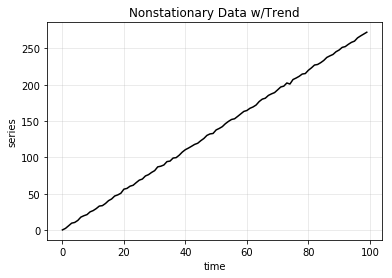

In [16]:
trend = (time * 2.75) + stationary
run_sequence_plot(time, trend,
                  title="Nonstationary Data w/Trend")

It's clear in the plot above that there is an upward trend. Suppose we take the mean of the series again. 

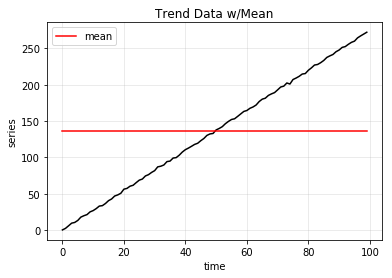

In [17]:
# find mean of series
trend_time_series_avg = np.mean(trend)

# create array of mean value equal to length of time array
trend_avg = np.full(shape=len(time), fill_value=trend_time_series_avg, dtype='float')

run_sequence_plot(time, trend,
                  title="Trend Data w/Mean")
plt.plot(time, trend_avg, 'r', label="mean")
plt.legend();

### 2. Moving Average Smoothing
The easiest way to understand moving average is by example. 

Say we have the values [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]. 

The first step is to select a window size. We'll choose a size of three arbitrarily. So what happens is we compute the average for the first three values and store the result. We then slide the window over one spot and calculate the average of the next three values. We continue this process until we reach the final observed value. 

Therefore, the window begins with the values [0, 1, 2]. The mean of that sequence is 1 so we store that value [1]. We slide the window over one place to [1, 2, 3] and compute the mean which is 2. We add that value to storage so we have [1, 2]. We continue this process until we reach the last window of size three [7, 8, 9]. We conclude by calculating the mean and storing the result. The result is an array of smoothed values: [1, 2, 3, 4, 5, 6, 7, 8]. 

Here's the cool part. Let's compare MSE for the two possibilities we've discussed thus far. 

In [33]:
# generate data for arrays discussed above
dummy_data=np.arange(10)
dummy_avg=np.mean(dummy_data)
dummy_avg_array=np.full(shape=len(dummy_data), fill_value=dummy_avg, dtype='float')

# calc MSE's
dummy_simple_average_mse=mse(dummy_data, dummy_avg_array)
dummy_smoothed_average_mse = mse(dummy_data[1:-1], np.arange(1, 9))

# print results
print("MSE")
print("-" * 12)
print("Simple: ", dummy_simple_average_mse)
print("Smoothed: ", dummy_smoothed_average_mse)

MSE
------------
Simple:  8.25
Smoothed:  0.0


Here we start to see the power of smoothing. A simple average of the trend data resulted in an abysmal MSE of 82.5 whereas a smoothed version of this contrived example produced a perfect estimation (MSE of 0). 
> An MSE of 0 is nearly always impossible unless you have toy data like this.

Let's create a moving average function to make this process easier moving forward.
> The guts of this function were taken from [this](https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy#14314054) stackoverflow.

In [36]:
def moving_average(observations, window=3, forecast=False):
    '''returns the smoothed version of an array of observations.'''
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    if forecast:
        return np.insert(cumulative_sum[window - 1:] / window, 0, np.zeros(3))
    else:
        return cumulative_sum[window - 1:] / window

Great, now let's calculate the moving average of the trend data.

In [37]:
smoothed_trend = moving_average(trend, window=3, forecast=False)

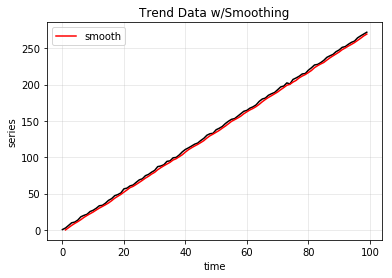

In [38]:
run_sequence_plot(time, trend,
                  title="Trend Data w/Smoothing")
plt.plot(time[1:], np.insert(smoothed_trend,0,0), 'r', label="smooth")
plt.legend();

Not bad at all! You can see the smoothed version picks up the trend rather nicely, far better than the simple average. Now we're getting somewhere.

Let's try the same thing with seasonality.

In [39]:
seasonality = 10 + np.sin(time) * 10
smoothed_seasonality = moving_average(seasonality, window=3, forecast=False)

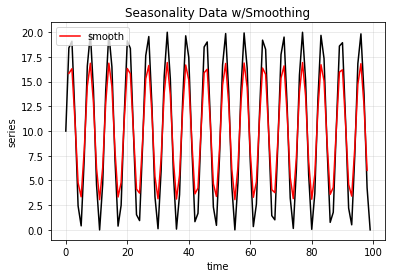

In [40]:
run_sequence_plot(time, seasonality,
                  title="Seasonality Data w/Smoothing")
plt.plot(time[1:-1], smoothed_seasonality, 'r', label="smooth")
plt.legend(loc='upper left');

It's far from perfect but clearly picks up the inherent pattern contained within this seasonal pattern.

Lastly, let's see how moving average handles trend, seasonality, and a bit of noise.

In [41]:
trend_seasonality = trend + seasonality + stationary
smoothed_trend_seasonality = moving_average(trend_seasonality, window=3, forecast=False)

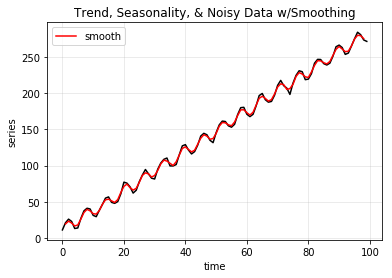

In [42]:
run_sequence_plot(time, trend_seasonality,
                  title="Trend, Seasonality, & Noisy Data w/Smoothing")
plt.plot(time[1:-1], smoothed_trend_seasonality, 'r', label="smooth")
plt.legend(loc='upper left');

verall this method is doing a decent job on these toy datasets. You can see it's picking up key patterns in the data. However, we've been weighting all observations equally. If you think about time series data, though, you may quickly realize that the most recent observations tend to impact the current to a larger degree than older ones. 

This leads us to another averaging strategy: exponential smoothing.

#### 3. Exponential Smoothing
Exponential smoothing is a way to weight observations differently. Specifically, recent observations are weighted moreso than more distant ones. This makes intuitive sense. Think back to the stock market example that we discussed in past lessons. In general, it has been observed that today's price is a good predictor for tomorrow's price. Using an equally weighted smoothing process like the one introduced earlier would dilute that. However, by applying unequal weights to past observations, we can control how much each affects the future forecast. 

Let's make this concrete with an example. 

Say we have the values [1, 2, 4, 16, 256]. 

Instead of pulling out the inherent pattern within a series, let's use these smoothing functions to create forecasts. In other words, we'll apply the smoothing process and use the resulting value as the next data point.

With an equally weighted moving average discussed earlier we'd get a smoothed result that looks like this:

In [43]:
values = np.array([1, 2, 4, 8, 16, 32, 64])
ma_smoothed_vals = moving_average(values, window=3, forecast=True)

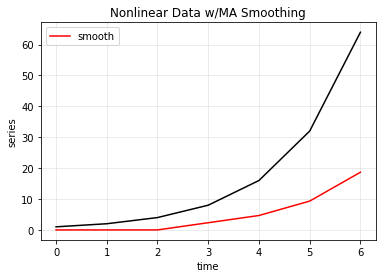

In [44]:
t = np.arange(len(values))
run_sequence_plot(t, values,
                  title="Nonlinear Data w/MA Smoothing")
plt.plot(t, ma_smoothed_vals[:-1], 'r', label="smooth")
plt.legend(loc='upper left');

Now let's weight recent values more aggressively than older values. 

We'll use a simple exponential weighting whereby $w_{1} + w_{2}^2 + w_{3}^3 = 1$. 

This means $w_{1}$ is ~0.543, $w_{2}$ is ~0.294, and $w_{3}$ is ~0.160.

In [46]:
def ewma(observations, forecast=True):
    '''returns the exponentially weighted smoothed version of an array of observations.'''
    weights = np.array([0.160, 0.294, 0.543])
    output = np.zeros_like(observations, dtype='float')
    for i, _ in enumerate(observations):
        if (i == 0) or (i == 1) or (i == len(observations) - 1):
            pass
        else:
            output[i] = np.dot(observations[i-2:i+1], weights)
    if forecast:
        return np.insert(output, 0, 0)
    else:
        return output

In [47]:
ewma_smoothed_vals = ewma(values, forecast=True)

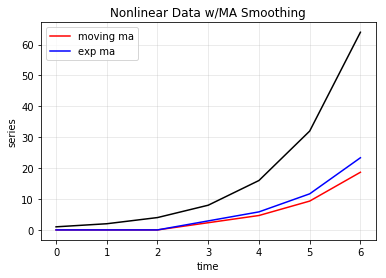

In [48]:
run_sequence_plot(t, values,
                  title="Nonlinear Data w/MA Smoothing")
plt.plot(t, ma_smoothed_vals[:-1], 'r', label="moving ma")
plt.plot(t, ewma_smoothed_vals[:-1], 'b', label="exp ma")
plt.legend(loc='upper left');

#### Three Types of Exponential Smoothing

There are three key exponential smoothing techniques you need to be aware of:
1. Single Exponential Smoothing - no trend or seasonality
2. Double Exponential Smoothing - captures trend
3. Triple Exponential Smoothing - captures trend & seasonality

#### Single Exponential
This method is useful if your data lacks trend and seasonality and you want to approximately track patterns in your data. Furthermore, this method removes the lag associated with the moving average techniques discussed above. 

#### Double Exponential 
Should your data exhibit a trend, you'll want to use this smoothing method. It has all the benefits of Single Exponential with the ability to pickup on trend. 

#### Triple Exponential
Should your data exhibit trend and seasonality, you'll want to use this smoothing method. It has all the benefits of Double Exponential with the ability to pickup on seasonality. 